<h1><center>Computational Finance</center></h1>
<h2>Mohammad Nayil Kalla</h2>
<h2>M2 IREF FQA</h2>
<h2>Université de Bordeaux</h2>

# Introduction

Nous nous proposons dans ce projet de backtester

In [27]:
import sys
sys.path.insert(0, "./ffn-master/")
import ffn

import bt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Importation des données

In [13]:
#A) Données d'entrainement
beginning_train = "01/01/2011"
end_train = "01/01/2016"

data_sp500_train = bt.get('^GSPC', start = beginning_train, end = end_train)

equity_list = ['AAPL', 'MCD', 'MSFT', 'TGT', 'GE', 'AMZN', 'T','UPS', 'GM', 'IBM', 
               'PEP', 'VZ', 'DIS', 'INTC','FORD', 'CMCSA', 'IEF']

data_train = bt.get(equity_list, start = beginning_train, end = end_train)

#B) Données de test
beginning_test = "01/01/2016"
end_test = "13/12/2018"

data_sp500_test = bt.get('^GSPC', start=beginning_test, end = end_test)

equity_list = ['AAPL', 'MCD', 'MSFT', 'TGT', 'GE', 'AMZN', 'T','UPS', 'GM', 'IBM', 
               'PEP', 'VZ', 'DIS', 'INTC','FORD', 'CMCSA', 'IEF']

data_test = bt.get(equity_list, start = beginning_test, end = end_test)

# II) Définition des stratégies

# Stratégie 1:

In [14]:
def ecart_type_moyenne_mobile(data, period = 10, treshold = 0.05):
    
    daily_standard_deviation = data.rolling(period).std()
    moving_average_data = data.rolling(period).mean()
    
    selection = (daily_standard_deviation / moving_average_data) < treshold
    
    return selection

# Stratégie 2:

In [15]:
def CCI(data, period = 400, treshold = 100, short = 0.0):
    
    moving_average_data = data.rolling(period).mean()
    moving_average_absolute_deviation = data.mad()
    CCI = (data - moving_average_data)/(moving_average_absolute_deviation*0.015)
    
    signal = CCI.copy()
    signal[CCI > treshold] = 1.0
    signal[CCI <= treshold] = short
    signal[CCI.isnull()] = 1
    signal = signal.div(signal.sum(axis=1), axis=0)
    
    return signal

# Stratégie 3:

In [16]:
def crossover(data, fast = 20, slow = 100, short = 0.0):
    
    moving_average_fast = data.rolling(fast).mean()
    moving_average_slow = data.rolling(slow).mean()
    
    signal = moving_average_slow.copy()
    signal[moving_average_fast > moving_average_slow] = 1.0
    signal[moving_average_fast < moving_average_slow] = short
    signal[moving_average_slow.isnull()] = 0
    signal = signal.div(signal.sum(axis=1), axis=0)
    
    return signal

# Stratégie 4:

In [17]:
def signal_line_crossover(data, short_ema = 12, long_ema = 26, MACD_ema = 9, short = -1.0 ):
    
    ema_short = data.ewm(span = short_ema, adjust=False).mean()
    ema_long = data.ewm(span= long_ema, adjust=False).mean()
    MACD = ema_short - ema_long
    ema_MACD = MACD.ewm(span = MACD_ema, adjust=False).mean()
    
    signal = MACD.copy()
    signal[MACD > ema_MACD] = 1.0
    signal[MACD < ema_MACD] = short
    signal[MACD.isnull()] = 0
    signal = signal.div(signal.sum(axis=1), axis=0)
    
    return signal

# Stratégie 5:

In [18]:
def zero_crossover(data, short_ema = 12, long_ema = 26, short = -1.0 ):
    
    ema_short = data.ewm(span = short_ema, adjust=False).mean()
    ema_long = data.ewm(span= long_ema, adjust=False).mean()
    MACD = ema_short - ema_long
    
    signal = MACD.copy()
    signal[MACD > 0] = 1.0
    signal[MACD < 0] = short
    signal[MACD.isnull()] = 0
    signal = signal.div(signal.sum(axis=1), axis=0)

    return signal

# Stratégie 6:

In [19]:
def bollinger(data, period = 20):
    
    middle_band = data.rolling(period).mean()
    upper_band = middle_band + 2 * data.rolling(period).std()
    lower_band = middle_band - 2 * data.rolling(period).std()
    
    signal = data.copy()
    signal[data > upper_band] = -1
    signal[data < lower_band] = 1
    signal[data.isnull()] = 0
    signal = signal.div(signal.sum(axis=1), axis=0)
    
    return signal

# III) Backtest des stratégies sur la période 2011-2016 

In [20]:
def list_strategies(data_sp500,data):
    
    s_sp500 = bt.Strategy('S&P 500 only',[bt.algos.RunMonthly(),
                                          bt.algos.SelectAll(),
                                          bt.algos.WeighEqually(),
                                          bt.algos.Rebalance()])
    b_sp500 = bt.Backtest(s_sp500, data_sp500)
    
    s_1 = bt.Strategy('s1', [bt.algos.RunDaily(),
                             bt.algos.SelectWhere(ecart_type_moyenne_mobile(data)),
                             bt.algos.WeighEqually(),
                             bt.algos.Rebalance()])
    b_1 = bt.Backtest(s_1, data)
    
    s_2 = bt.Strategy('s2', [bt.algos.RunMonthly(),
                             bt.algos.SelectAll(),
                             bt.algos.WeighTarget( CCI(data,400,100,-1)),
                             bt.algos.Rebalance()])
    b_2 = bt.Backtest(s_2, data)
    
    s_3 = bt.Strategy('s3', [bt.algos.RunWeekly(),
                             bt.algos.SelectAll(),
                             bt.algos.WeighTarget( crossover(data)),
                             bt.algos.Rebalance()])
    b_3 = bt.Backtest(s_3, data)
    
    s_4 = bt.Strategy('s4', [bt.algos.RunWeekly(),
                             bt.algos.SelectAll(),
                             bt.algos.WeighTarget( signal_line_crossover(data)),
                             bt.algos.Rebalance()])
    b_4 = bt.Backtest(s_4, data)
    
    s_5 = bt.Strategy('s5', [bt.algos.RunWeekly(),
                             bt.algos.SelectAll(),
                             bt.algos.WeighTarget( zero_crossover(data)),
                             bt.algos.Rebalance()])
    b_5 = bt.Backtest(s_5, data)
    
    s_6 = bt.Strategy('s6', [bt.algos.RunWeekly(),
                             bt.algos.SelectAll(),
                             bt.algos.WeighTarget( bollinger(data)),
                             bt.algos.Rebalance()])
    b_6 = bt.Backtest(s_6, data)
    
    return b_sp500,[b_1,b_2,b_3,b_4,b_5,b_6]

s1
0% [############################# ] 100% | ETA: 00:00:00S&P 500 only
0% [############################# ] 100% | ETA: 00:00:00s2
0% [############################# ] 100% | ETA: 00:00:00s3
0% [############################# ] 100% | ETA: 00:00:00s4
0% [############################# ] 100% | ETA: 00:00:00s5
0% [############################# ] 100% | ETA: 00:00:00s6
0% [############################# ] 100% | ETA: 00:00:00

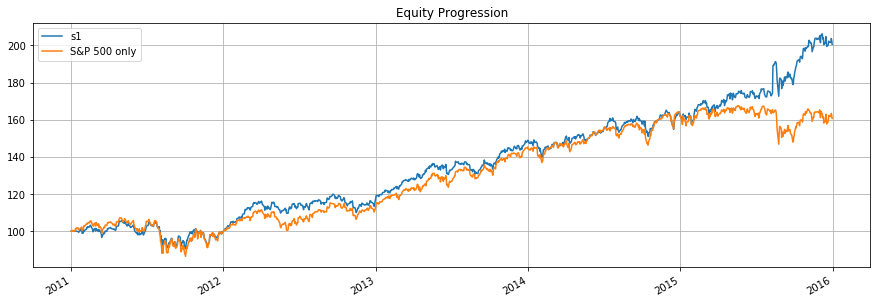

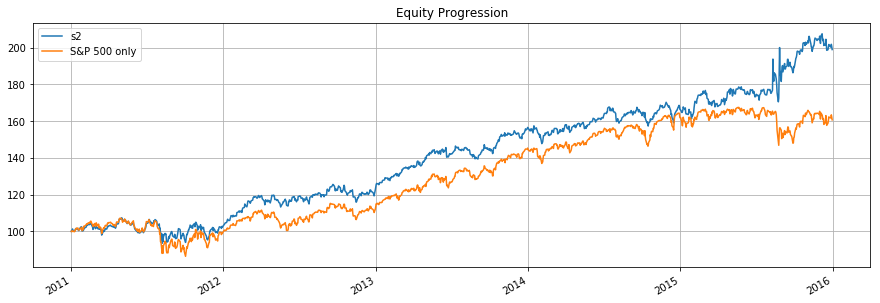

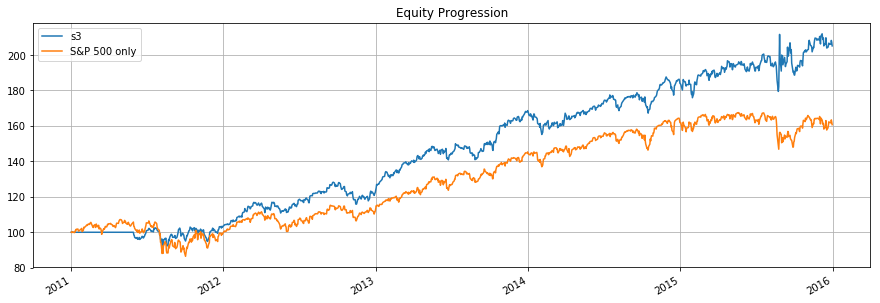

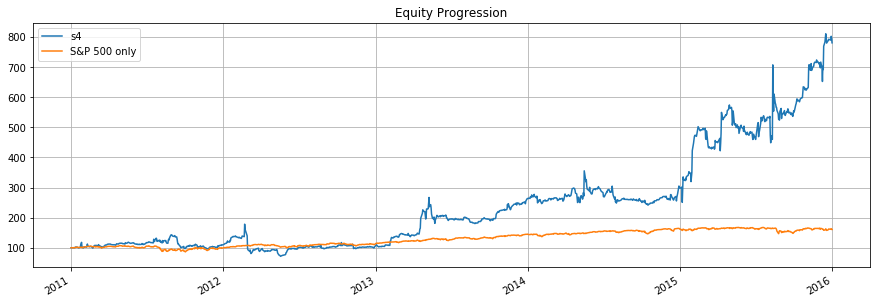

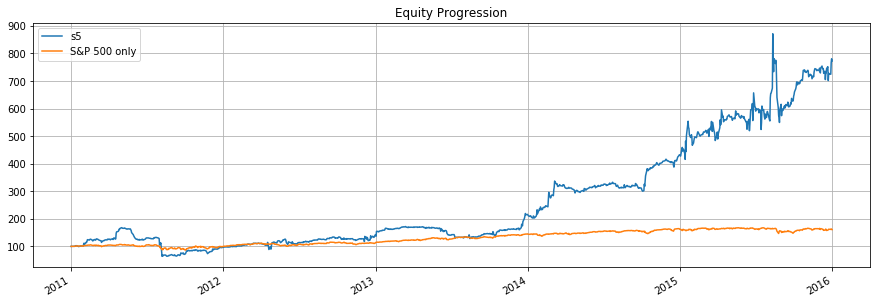

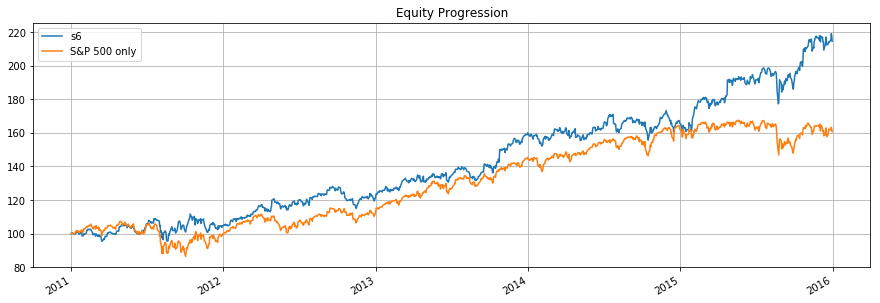

In [23]:
b_sp500, liste_strategies = list_strategies(data_sp500_train, data_train)

for i in liste_strategies:
    result = bt.run(i, b_sp500)
    result.plot().grid()

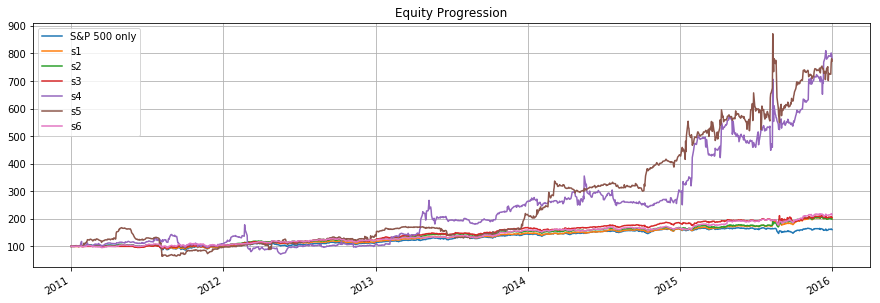

In [24]:
result = bt.run(b_sp500, *liste_strategies)
result.plot().grid()

s_c


C:\Users\Nayil\Anaconda3\lib\site-packages\ffn\core.py:1411: RuntimeWarning: divide by zero encountered in divide
  vol = np.divide(1. , np.std(returns,ddof=1) )


0% [############################# ] 100% | ETA: 00:00:02S&P 500 only
0% [############################# ] 100% | ETA: 00:00:00

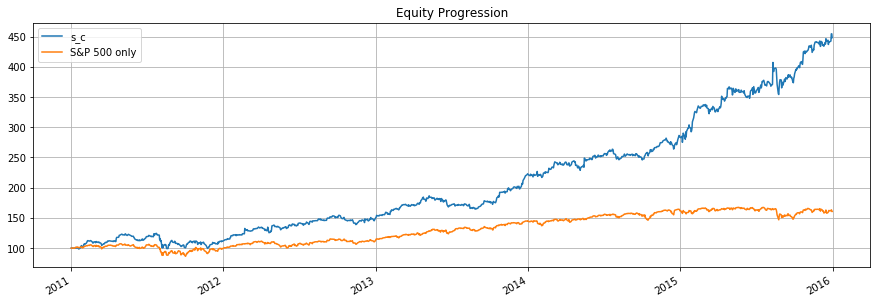

In [25]:
b_sp500, liste_strategies = list_strategies(data_sp500_train, data_train)

s_c = bt.Strategy('s_c', [bt.algos.SelectAll(),bt.algos.WeighInvVol(),bt.algos.Rebalance()],[i.strategy for i in liste_strategies[3:6]])
b_c = bt.Backtest(s_c, data_train)

result_sc = bt.run(b_c, b_sp500)
result_sc.plot().grid()

# IV) Test de la stratégie sélectionnée sur la période 2016-2018

s_c
0% [############################# ] 100% | ETA: 00:00:01S&P 500 only
0% [############################# ] 100% | ETA: 00:00:00

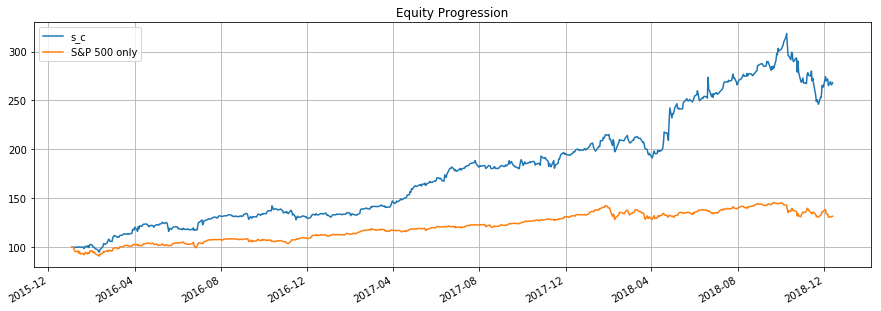

In [26]:
b_sp500, liste_strategies = list_strategies(data_sp500_test, data_test)

s_c = bt.Strategy('s_c', [bt.algos.SelectAll(),
                          bt.algos.WeighInvVol(),
                          bt.algos.Rebalance()], 
                  [i.strategy for i in liste_strategies[3:6]])

b_c = bt.Backtest(s_c, data_test)

result_sc = bt.run(b_c, b_sp500)
result_sc.plot().grid()

# Conclusion